In [38]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("punkt")
from sklearn.model_selection import KFold
nltk.download("stopwords")
nltk.download("wordnet")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, GRU, Activation, LSTM, Bidirectional, MultiHeadAttention, Concatenate, Dropout, Add, Lambda, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers.schedules import CosineDecay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import re
#from gensim.models import Word2Vec
import plotly.express as px
import keras.backend as K
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from scipy.stats import entropy


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yassineseidou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yassineseidou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yassineseidou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Lire le fichier texte et ajouter toutes les lignes dans une liste
with open("fleurs_mal.txt", 'r' , encoding = 'utf8') as f:
    lines = f.readlines()

df = ''.join(lines)

tokens = word_tokenize(df.lower())
print("There are :",len(tokens), "words in the document")
print("There are :",len(set(tokens)), "unique words in the document")

There are : 32562 words in the document
There are : 6975 unique words in the document


## Analyse Exploratoire

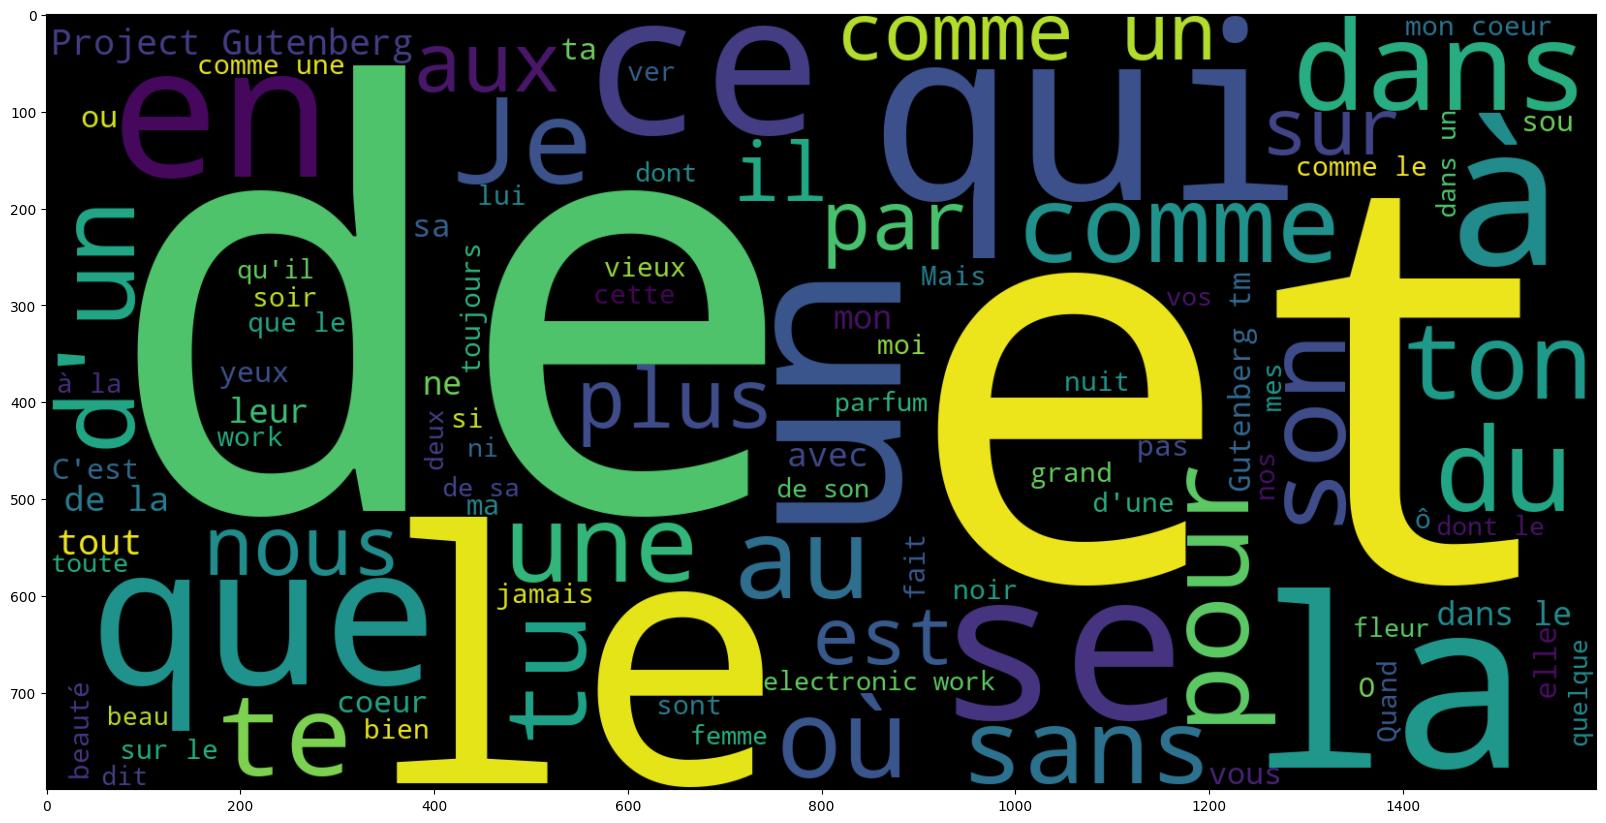

In [4]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=100,
               height=800,
               width=1600,
               ).generate(df)
plt.imshow(wc, interpolation="bilinear")

# visualize the distribution of number of words in a text

fig = px.histogram(x = [len(x) for x in tokens], nbins = 100)
fig.show()

In [5]:
stop_words = stopwords.words('french')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'le', 'la', 'du', 'des', 'un', 'une', 'a'])
stop_words

['au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'ils',
 'je',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'c',
 'd',
 'j',
 'l',
 'à',
 'm',
 'n',
 's',
 't',
 'y',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',
 'fûmes',
 'fûtes',
 'furent',
 'sois',
 'soit',
 'soyons',
 'soyez',
 'soient',
 'fusse',
 'fusses',
 'fût',
 'fussions',
 'fussiez',
 'fussent',
 'ayant',
 'ayante',
 'ayantes',


In [6]:
len(stop_words)

157

## Traitement du texte

In [7]:
# Initialisation du lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, stop_words):
    """
    Nettoie et prétraite le texte :
    - Met en minuscule
    - Supprime les caractères spéciaux
    - Tokenize
    - Retire les stopwords
    - Lematise les mots restants
    """
    # Convertir en minuscule
    text = text.lower()
    
    # Supprimer les caractères spéciaux (on garde les mots uniquement)
    text = re.sub(r"[^\w\s]", "", text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Retirer les stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

In [8]:
# Appliquer la fonction au corpus
preprocessed_tokens = preprocess_text(df, stop_words)

In [9]:
# Vérifier les résultats
print("Exemple de tokens prétraités :", preprocessed_tokens[:50])
print("Nombre total de mots après prétraitement :", len(preprocessed_tokens))
print("Nombre de mots uniques après prétraitement :", len(set(preprocessed_tokens)))


Exemple de tokens prétraités : ['the', 'project', 'gutenberg', 'ebook', 'of', 'fleurs', 'mal', 'by', 'charles', 'baudelaire', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restriction', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 'reuse', 'it', 'under', 'the', 'term', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook']
Nombre total de mots après prétraitement : 18235
Nombre de mots uniques après prétraitement : 6654


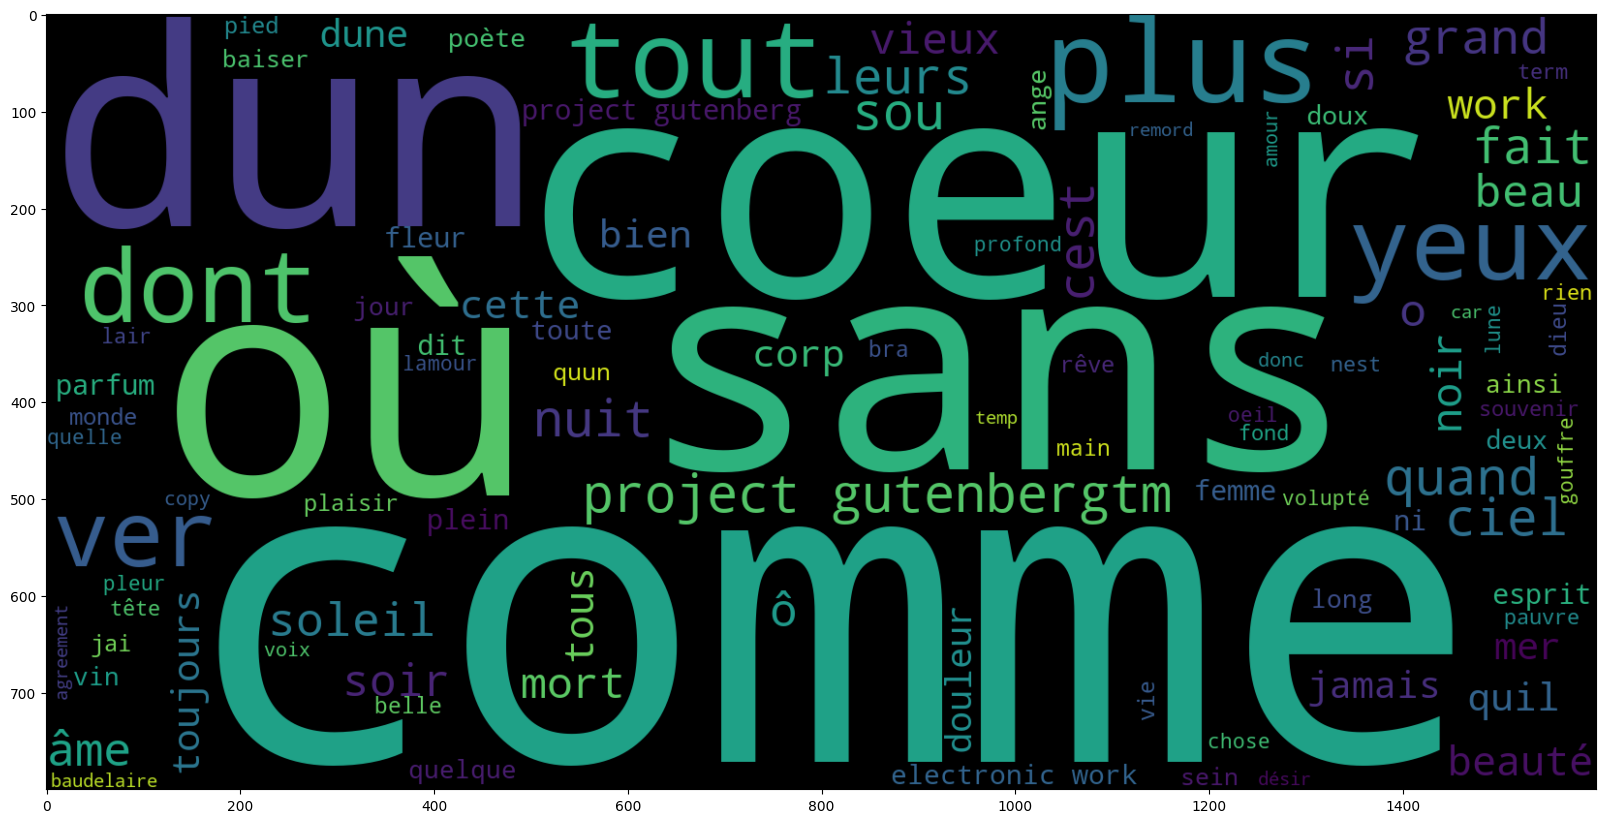

In [10]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=100,
               height=800,
               width=1600,
               ).generate(" ".join(preprocessed_tokens))
plt.imshow(wc, interpolation="bilinear")

# Distribution de la longueur des textes après prétraitement
fig = px.histogram(x=[len(x) for x in preprocessed_tokens], nbins=100)
fig.show()

In [11]:
# Convertir les tokens en texte (si besoin pour d'autres étapes)
cleaned_text = " ".join(preprocessed_tokens)

In [12]:
for idx, line in enumerate(preprocessed_tokens):
    if "Charles Baudelaire" in line:
        first_line = idx
    if "End of the Project" in line:
        last_line = idx

In [13]:
first_line = None
last_line = None
lines = lines[first_line:last_line]
lines = [l.lower().strip().replace('_', '') for l in lines if len(l) > 1]
text = " ".join(lines)

In [14]:
characters = sorted(set(text))
n_characters = len(characters)

In [15]:
n_characters

72

In [16]:
# SEQLEN représente la taille de la séquence de lettres à passer en entrée
SEQLEN = 10
step = 1
input_characters, labels = [], []
# On parcourt le corpus de texte avec une fenêtre glissante
for i in range(0, len(text) - SEQLEN, step):
    input_characters.append(text[i:i + SEQLEN])
    labels.append(text[i + SEQLEN])

print(f"Il y a {len(input_characters)} séquences de {SEQLEN} caractères dans le corpus d'entraînement.")

Il y a 165482 séquences de 10 caractères dans le corpus d'entraînement.


In [17]:
# Encodage caractère -> indice du dictionaire
char2index = dict((c, i) for i, c in enumerate(characters))
# Encodage de l'indice vers le caractère (utilisé pour décoder les prédictions du modèle)
index2char = dict((i, c) for i, c in enumerate(characters)) # mapping index -> char in dictionary

In [18]:


# Initialisation des tenseurs
X = np.zeros((len(input_characters), SEQLEN, n_characters), dtype=bool)
y = np.zeros((len(input_characters), n_characters), dtype=bool)

# Remplissage des tenseurs X et y
for idx_seq, sequence in enumerate(input_characters):
    for idx_char, char in enumerate(sequence):
        # Encode chaque caractère dans une représentation one-hot
        X[idx_seq, idx_char, char2index[char]] = 1
    # Encode le caractère cible correspondant
    y[idx_seq, char2index[labels[idx_seq]]] = 1

print("Encodage terminé.")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Encodage terminé.
X shape: (165482, 10, 72), y shape: (165482, 72)


In [19]:
#from sklearn.model_selection import train_test_split

# 80% des données en apprentissage, 20% en validation
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

### Model

In [20]:
class CosineAnnealingScheduler(Callback):
    def __init__(self, max_lr, min_lr, total_epochs):
        super(CosineAnnealingScheduler, self).__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        # Calcul du nouveau learning rate
        cosine_lr = self.min_lr + 0.3 * (self.max_lr - self.min_lr) * (
            1 + np.cos(np.pi * epoch / self.total_epochs)
        )
        
        # Mise à jour du learning rate de l'optimiseur
        K.set_value(self.model.optimizer.lr, cosine_lr)

        print(f"Epoch {epoch+1}: Learning rate is {cosine_lr:.6f}")

In [25]:
# Paramètres
h_size = 128
dropout_rate = 0.2
weight_decay = 0.0001
batch_size = 128
num_epochs = 20
initial_learning_rate = 0.001
k = 10  # Nombre de folds pour la validation croisée

# Définition de l'entrée
inputs = Input(shape=(SEQLEN, n_characters))

# Construction du modèle avec skip connections
x = GRU(h_size, return_sequences=True, kernel_regularizer=l2(weight_decay), unroll=True)(inputs)
x = BatchNormalization()(x)
skip_1 = x

x = GRU(h_size, return_sequences=True, kernel_regularizer=l2(weight_decay), unroll=True)(x)
x = BatchNormalization()(x)
x = Add()([x, skip_1])
x = Dropout(dropout_rate)(x)
skip_2 = x

x = GRU(h_size, return_sequences=True, kernel_regularizer=l2(weight_decay), unroll=True)(x)
x = BatchNormalization()(x)
x = Add()([x, skip_2])
x = Dropout(dropout_rate)(x)
skip_3 = x

x = GRU(h_size, return_sequences=True, kernel_regularizer=l2(weight_decay), unroll=True)(x)
x = BatchNormalization()(x)
x = Add()([x, skip_3])
x = Dropout(dropout_rate)(x)
skip_4 = x

x = GRU(h_size, return_sequences=False, kernel_regularizer=l2(weight_decay), unroll=True)(x)
x = BatchNormalization()(x)
x = Add()([x, skip_4[:, -1, :]])
x = Dropout(dropout_rate)(x)

outputs = Dense(n_characters, kernel_regularizer=l2(weight_decay))(x)
outputs = Activation("softmax")(outputs)

# Création du modèle
model = Model(inputs, outputs)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=initial_learning_rate), metrics=['accuracy'])


# Résumé du modèle
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 10, 72)]             0         []                            
                                                                                                  
 gru_10 (GRU)                (None, 10, 128)              77568     ['input_3[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 10, 128)              512       ['gru_10[0][0]']              
 tchNormalization)                                                                                
                                                                                                  
 gru_11 (GRU)                (None, 10, 128)              99072     ['batch_normalization_10


🔹 Fold 1/10 : Entraînement en cours...

Epoch 1: Learning rate is 0.003040
Epoch 1/20
1164/1164 [==============================] - 101s 82ms/step - loss: 2.5432 - accuracy: 0.3166 - val_loss: 2.1161 - val_accuracy: 0.3925
Epoch 2: Learning rate is 0.003022
Epoch 2/20
1164/1164 [==============================] - 104s 90ms/step - loss: 2.1936 - accuracy: 0.3853 - val_loss: 2.0258 - val_accuracy: 0.4197
Epoch 3: Learning rate is 0.002968
Epoch 3/20
1164/1164 [==============================] - 97s 84ms/step - loss: 2.1213 - accuracy: 0.4098 - val_loss: 1.9706 - val_accuracy: 0.4458
Epoch 4: Learning rate is 0.002880
Epoch 4/20
1164/1164 [==============================] - 100s 86ms/step - loss: 2.0748 - accuracy: 0.4252 - val_loss: 1.9471 - val_accuracy: 0.4560
Epoch 5: Learning rate is 0.002759
Epoch 5/20
1164/1164 [==============================] - 102s 88ms/step - loss: 2.0412 - accuracy: 0.4364 - val_loss: 1.9191 - val_accuracy: 0.4646
Epoch 6: Learning rate is 0.002609
Epoch 6/20
1164

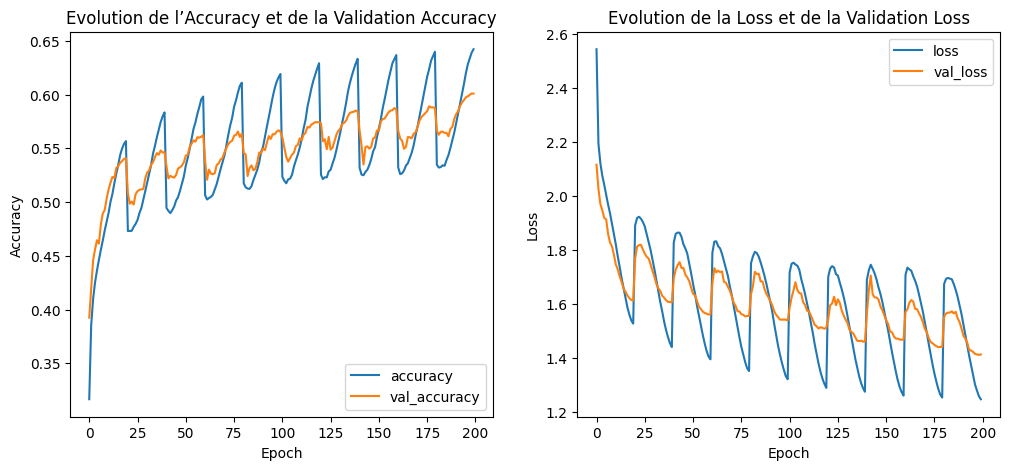

In [26]:
# Callbacks
cosine_scheduler = CosineAnnealingScheduler(max_lr=0.005, min_lr=0.0001, total_epochs=num_epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Initialisation du k-Fold Cross-Validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_accuracies = []
history_dict = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n🔹 Fold {fold+1}/{k} : Entraînement en cours...\n")
    
    # Séparer les données pour ce fold
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Entraînement du modèle sur ce fold
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[cosine_scheduler])

    # Stocker l'historique
    for key in history.history.keys():
        history_dict[key].extend(history.history[key])

    # Évaluer la performance sur ce fold
    scores = model.evaluate(X_val, y_val, verbose=1)
    fold_accuracies.append(scores[1])

# Affichage des performances moyennes
print(f"\n✅ Performances moyennes sur les {k} folds : {np.mean(fold_accuracies) * 100:.2f}%")

# 🔹 Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='accuracy')
plt.plot(history_dict['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Evolution de l’Accuracy et de la Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='loss')
plt.plot(history_dict['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Evolution de la Loss et de la Validation Loss')

plt.show()



In [29]:
# 🔹 Ajout du Test-Time Scaling (TTS)
def apply_temperature_scaling(logits, temperature=2.0):
    """Applique le Temperature Scaling aux logits avant la softmax."""
    return logits / temperature

# Inférence avec TTS
def inference_with_tts(model, X_test, temperature=2.0):
    logits = model.predict(X_test)
    scaled_logits = apply_temperature_scaling(logits, temperature)
    probabilities = tf.nn.softmax(scaled_logits).numpy()
    return probabilities

# Test du modèle après TTS
scaled_predictions = inference_with_tts(model, X_val, temperature=2.0)

# 🔹 Affichage des résultats avant/après TTS
print(f"\n🔹 Exemple de prédiction avant TTS : {tf.nn.softmax(model.predict(X_val[:1]))}")
print(f"🔹 Exemple de prédiction après TTS : {scaled_predictions[:1]}")


1/1 [==============================] - 0s 10ms/step

🔹 Exemple de prédiction avant TTS : [[0.01356517 0.01356517 0.01356517 0.01356517 0.01356517 0.01356517
  0.01356517 0.01356517 0.01356517 0.01356517 0.01356517 0.01356517
  0.01356517 0.01356517 0.01356517 0.01356517 0.01356517 0.01356517
  0.01356517 0.01356517 0.01356517 0.01356517 0.01356517 0.01356517
  0.01356517 0.01356517 0.01356517 0.01356517 0.01356517 0.01356517
  0.01356517 0.01356517 0.01356527 0.01356517 0.01356517 0.01356517
  0.01356517 0.01356517 0.01356517 0.01356517 0.01356517 0.01356517
  0.01356517 0.01356517 0.01356517 0.01356517 0.01356517 0.01356517
  0.01356518 0.03687266 0.01356517 0.01356517 0.01356517 0.01356551
  0.01356517 0.01356517 0.01356517 0.01356517 0.01356517 0.01356517
  0.01356517 0.01356517 0.01356517 0.01356517 0.01356517 0.01356517
  0.01356517 0.01356517 0.01356517 0.01356517 0.01356517 0.01356517]]
🔹 Exemple de prédiction après TTS : [[0.01376487 0.01376487 0.01376487 0.01376487 0.01376487 

Layer input_3 is not a SimpleRNN, GRU, or Dense layer.
Layer: gru_10
Weights shape: (72, 384), Biases shape: (128, 384)


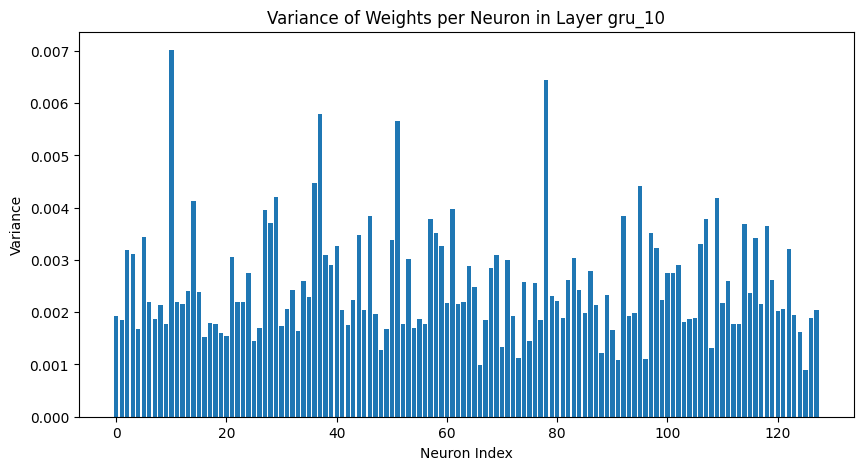

Biases in layer gru_10 have a complex shape and cannot be plotted directly.
Layer batch_normalization_10 is not a SimpleRNN, GRU, or Dense layer.
Layer: gru_11
Weights shape: (128, 384), Biases shape: (128, 384)


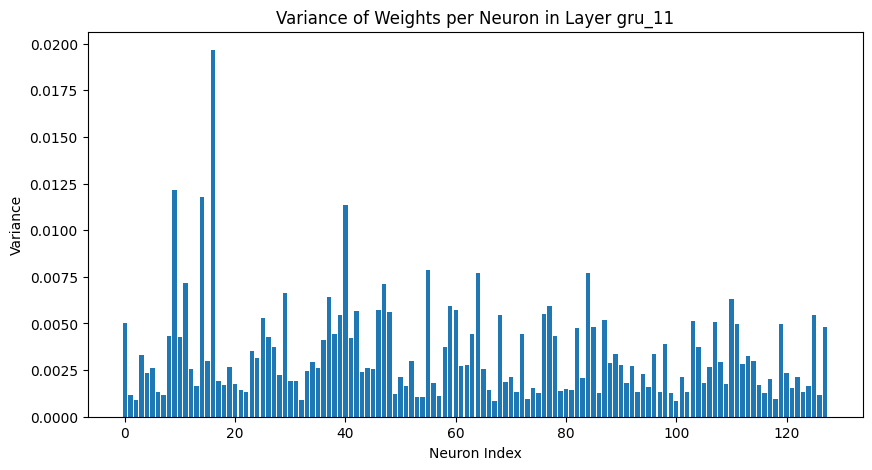

Biases in layer gru_11 have a complex shape and cannot be plotted directly.
Layer batch_normalization_11 is not a SimpleRNN, GRU, or Dense layer.
Layer add_8 is not a SimpleRNN, GRU, or Dense layer.
Layer dropout_8 is not a SimpleRNN, GRU, or Dense layer.
Layer: gru_12
Weights shape: (128, 384), Biases shape: (128, 384)


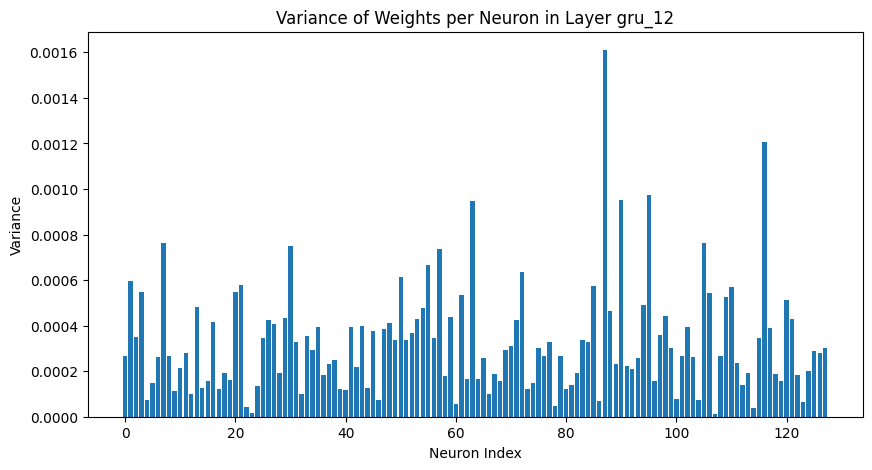

Biases in layer gru_12 have a complex shape and cannot be plotted directly.
Layer batch_normalization_12 is not a SimpleRNN, GRU, or Dense layer.
Layer add_9 is not a SimpleRNN, GRU, or Dense layer.
Layer dropout_9 is not a SimpleRNN, GRU, or Dense layer.
Layer: gru_13
Weights shape: (128, 384), Biases shape: (128, 384)


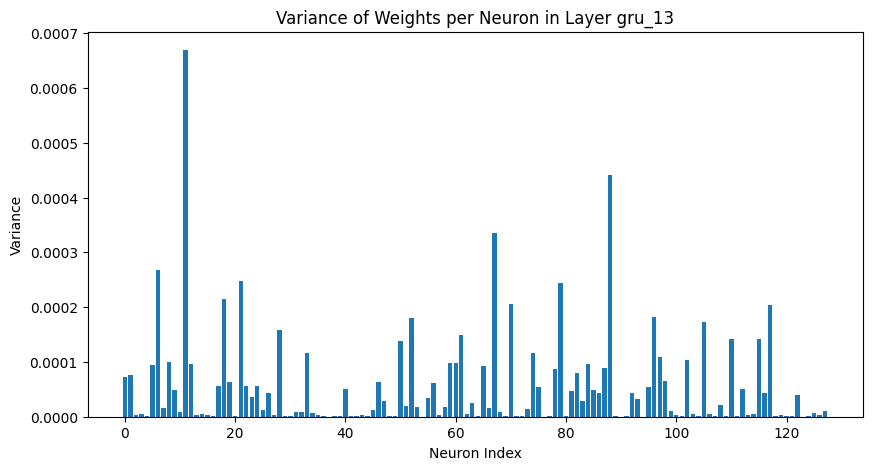

Biases in layer gru_13 have a complex shape and cannot be plotted directly.
Layer batch_normalization_13 is not a SimpleRNN, GRU, or Dense layer.
Layer add_10 is not a SimpleRNN, GRU, or Dense layer.
Layer dropout_10 is not a SimpleRNN, GRU, or Dense layer.
Layer: gru_14
Weights shape: (128, 384), Biases shape: (128, 384)


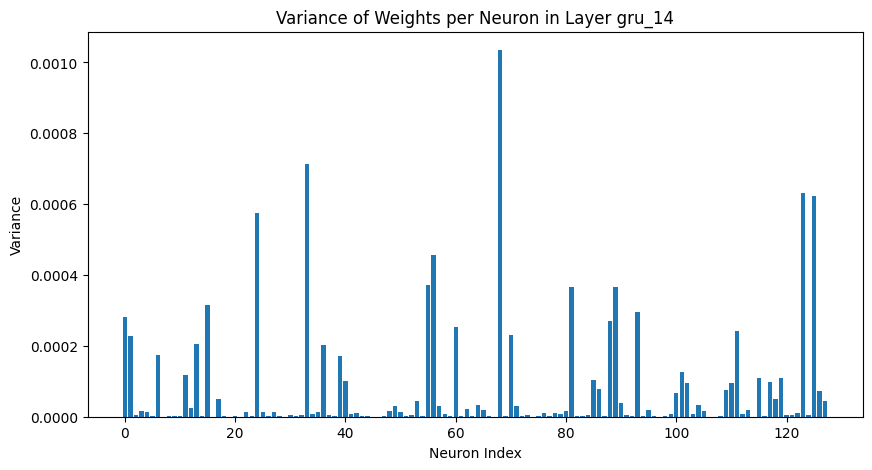

Biases in layer gru_14 have a complex shape and cannot be plotted directly.
Layer batch_normalization_14 is not a SimpleRNN, GRU, or Dense layer.
Layer tf.__operators__.getitem_2 is not a SimpleRNN, GRU, or Dense layer.
Layer add_11 is not a SimpleRNN, GRU, or Dense layer.
Layer dropout_11 is not a SimpleRNN, GRU, or Dense layer.
Layer: dense_2
Weights shape: (128, 72), Biases shape: (72,)


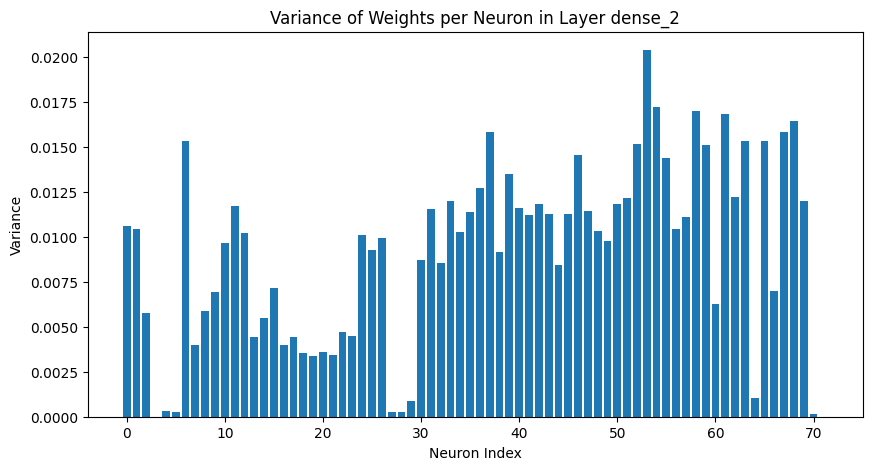

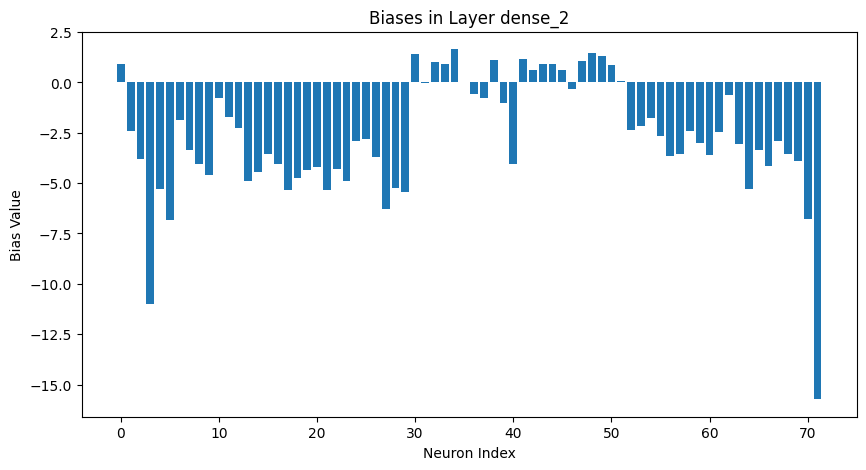

Layer activation_2 is not a SimpleRNN, GRU, or Dense layer.


In [30]:
def plot_layer_parameters(model):
    for layer in model.layers:
        if isinstance(layer, (SimpleRNN, GRU, Dense)):
            # Récupérer tous les poids de la couche
            layer_weights = layer.get_weights()
            
            # Vérifier le nombre de valeurs retournées
            if len(layer_weights) >= 2:
                weights = layer_weights[0]  # Les poids principaux
                biases = layer_weights[1]   # Les biais
                
                print(f"Layer: {layer.name}")
                print(f"Weights shape: {weights.shape}, Biases shape: {biases.shape}")
                
                # Calcul de la variance des poids par neurone
                if isinstance(layer, GRU):
                    # Pour GRU, les poids sont structurés différemment
                    weight_variances = np.var(weights, axis=0)
                    # Nous prenons la variance pour chaque unité
                    weight_variances = np.var(weights, axis=0)
                    num_units = layer.units
                    plt.figure(figsize=(10, 5))
                    plt.bar(range(num_units), weight_variances[:num_units])
                    plt.title(f'Variance of Weights per Neuron in Layer {layer.name}')
                    plt.xlabel('Neuron Index')
                    plt.ylabel('Variance')
                    plt.show()
                else:
                    weight_variances = np.var(weights, axis=0)
                    plt.figure(figsize=(10, 5))
                    plt.bar(range(len(weight_variances)), weight_variances)
                    plt.title(f'Variance of Weights per Neuron in Layer {layer.name}')
                    plt.xlabel('Neuron Index')
                    plt.ylabel('Variance')
                    plt.show()
                
                # Vérifier la forme des biais avant de les tracer
                if len(biases.shape) == 1:  # Si les biais sont unidimensionnels
                    plt.figure(figsize=(10, 5))
                    plt.bar(range(len(biases)), biases)
                    plt.title(f'Biases in Layer {layer.name}')
                    plt.xlabel('Neuron Index')
                    plt.ylabel('Bias Value')
                    plt.show()
                else:
                    print(f"Biases in layer {layer.name} have a complex shape and cannot be plotted directly.")
            else:
                print(f"Layer {layer.name} does not have standard weights and biases.")
        else:
            print(f"Layer {layer.name} is not a SimpleRNN, GRU, or Dense layer.")

# Appel de la fonction
plot_layer_parameters(model)

In [32]:
# 🔹 Évaluation finale
scores_train = model.evaluate(X_train, y_train, verbose=1)
scores_test = model.evaluate(X_val, y_val, verbose=1)

print(f"📊 Performances finales (apprentissage, {model.metrics_names[1]}) = {scores_train[1]*100:.2f}%")
print(f"📊 Performances finales (validation, {model.metrics_names[1]}) = {scores_test[1]*100:.2f}%")


518/518 [==============================] - 4s 7ms/step - loss: 1.4138 - accuracy: 0.6009
📊 Performances finales (apprentissage, accuracy) = 69.19%
📊 Performances finales (validation, accuracy) = 60.09%


In [ ]:
#model_name = f"SimpleRNN_{h_size}_{num_epochs}epochs"
#model.save(model_name)

In [ ]:
#from tensorflow.keras.models import load_model
#model = load_model(model_name)
#model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
#model.summary()

In [33]:
idx = 10
# index2char permet de repasser de l'encodage one-hot au caractère du dictionnaire
initial_characters = [index2char[np.argmax(c)] for c in X_train[idx]]
initial_text = "".join(initial_characters)
print(f"La séquence n°{idx} est : '{initial_text}'")

La séquence n°10 est : 't gutenber'


In [34]:
test_sequence = np.zeros((1, SEQLEN, n_characters), dtype=bool)
test_sequence[0] = X_train[idx]
prediction = model.predict(test_sequence)
print(prediction)

1/1 [==============================] - 0s 12ms/step
[[4.78637673e-07 2.89919804e-08 9.44818357e-09 1.98320332e-12
  6.34216735e-10 2.50652832e-10 1.86493239e-07 9.14544496e-10
  2.87573521e-09 1.11237339e-10 5.77220263e-08 1.87353377e-09
  2.94703256e-07 3.26622018e-09 2.11396101e-09 6.40769215e-10
  6.23383940e-08 5.99528747e-08 9.29806721e-09 8.16830834e-08
  3.76309828e-09 2.85721484e-07 1.45919090e-08 2.36122055e-08
  1.21165716e-10 1.15976153e-08 8.80027784e-09 3.64079850e-10
  7.82506504e-10 8.51662574e-10 4.28041130e-10 1.08705945e-06
  2.10005510e-06 4.62681413e-07 4.07453683e-07 2.66029787e-07
  9.99985099e-01 1.80836057e-08 4.83934803e-09 5.80011017e-09
  5.99083614e-06 1.93646112e-08 1.16311103e-08 6.81152471e-07
  6.12871176e-08 1.25365629e-09 3.31151249e-08 5.89795227e-11
  9.85898474e-09 4.26622336e-07 6.55431875e-10 2.68214222e-07
  1.53833398e-07 2.96677172e-09 4.48428716e-09 7.38408374e-08
  1.47336032e-10 6.98080482e-13 4.38108527e-09 8.54594839e-10
  1.30035141e-06 3

In [35]:
def sample(probabilities, temperature=1.0):
    probabilities = np.asarray(probabilities).astype('float64')
    # Modifie la distribution selon la valeur de la température
    probabilities = pow(probabilities, 1.0/temperature)
    probabilities /= np.sum(probabilities)
    # Tire des variables aléatoires selon la distribution multinomiale transformée
    random_values = np.random.multinomial(1, probabilities, 1)
    # Renvoie le symbole échantillonné
    return np.argmax(random_values)

In [36]:
# Longueur du texte à générer (en caractères)
text_length = 200
# Température
temperature = 0.5

generated_text = initial_text
network_input = test_sequence

for i in range(text_length):
    last_characters = generated_text[-SEQLEN:]
    
    # Préparer l'entrée pour la prédiction
    test_sequence = np.zeros((1, SEQLEN, n_characters), dtype=bool)
    for t, char in enumerate(last_characters):
        test_sequence[0, t, char2index[char]] = 1
    
    # Prédiction du modèle
    prediction = model.predict(test_sequence, verbose=0)
    
    # Échantillonner un caractère à partir de la distribution de probabilité
    predicted_char_index = sample(prediction[0], temperature)
    predicted_char = index2char[predicted_char_index]
    
    # Ajouter le caractère prédit au texte généré
    generated_text += predicted_char

print("Texte généré:")
print(generated_text)

Texte généré:
t gutenberg-tm electronic works in the united states works in any project gutenberg-tm electronic works in any halmon on le jour de notre souvenir de la forme de la vie et du bour et de ces couleurs des deux po


In [59]:


# Fonction de softmax
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))  # Stabilité numérique
    return exp_logits / np.sum(exp_logits)

# Fonction de sampling avec température et top-k
def sample(preds, temperature=1.0, top_k=5):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-10) / temperature  # Appliquer température
    preds = softmax(preds)

    # Optionnel: Limiter aux k meilleures probabilités
    if top_k > 0:
        top_k_indices = np.argsort(preds)[-top_k:]
        preds_top_k = preds[top_k_indices]
        preds_top_k /= np.sum(preds_top_k)  # Renormaliser
        return np.random.choice(top_k_indices, p=preds_top_k)
    
    return np.random.choice(len(preds), p=preds)

# 3. Génération de texte avec self-probing et calcul de l'entropie
def generate_text_with_entropy(model, initial_text, text_length=200, temperature=0.7, num_samples=10, top_k=5):
    generated_texts = []
    entropies = []
    
    for _ in range(num_samples):
        generated_text = initial_text
        network_input = np.zeros((1, SEQLEN, n_characters), dtype=bool)
        for t, char in enumerate(initial_text):
            if char in char2index:
                network_input[0, t, char2index[char]] = 1
        
        for i in range(text_length):
            prediction = model.predict(network_input, verbose=0)[0]

            # Appliquer le sampling
            predicted_char_index = sample(prediction, temperature, top_k)
            predicted_char = index2char[predicted_char_index]
            
            # Ajouter le caractère prédit au texte généré
            generated_text += predicted_char
            
            # Mettre à jour l'entrée du réseau (Recréer plutôt que décaler)
            network_input = np.zeros((1, SEQLEN, n_characters), dtype=bool)
            last_chars = generated_text[-SEQLEN:]
            for t, char in enumerate(last_chars):
                if char in char2index:
                    network_input[0, t, char2index[char]] = 1
        
        generated_texts.append(generated_text)
        
        # Calcul de l'entropie sur la dernière sortie
        logits = model.predict(network_input, verbose=0)[0]
        probs = softmax(logits)  # Softmax appliqué correctement
        entropies.append(entropy(probs))
    
    return generated_texts, entropies

# Génération de texte avec self-probing et calcul de l'entropie
generated_texts, entropies = generate_text_with_entropy(model, initial_text, text_length=200, temperature=0.7, num_samples=10, top_k=5)

for i, (text, ent) in enumerate(zip(generated_texts, entropies)):
    print(f"Sample {i+1}:")
    print(text)
    print(f"Entropy: {ent:.4f}")
    print("-" * 80)

Sample 1:
t gutenberg-tm electronic works in the united states without pouttre paster et charmé de son prime incorturelent d'un peintre un soleil couter des maisreaue et dont le souvenir dans un tapis de ton amour naisse
Entropy: 4.2700
--------------------------------------------------------------------------------
Sample 2:
t gutenberg-tm license all le pence les ressemins et le vent des démons pour qui de la fraise en voyage le long des pelus, et tes pousses les seins du carps et les cieux de sa forme conside la gronde dit, mon c
Entropy: 4.2679
--------------------------------------------------------------------------------
Sample 3:
t gutenberg-tm electronic works in any project gutenberg literary archive foundation and distributing a repose de l'insolenle de l'arme les morts, s'avanse et le vin de loin des sommeils de son francherre son l
Entropy: 4.2751
--------------------------------------------------------------------------------
Sample 4:
t gutenberg literary archive foundat

In [60]:
entropies

[4.26998,
 4.267866,
 4.2751007,
 4.265259,
 4.272597,
 4.2653513,
 4.2758355,
 4.275633,
 4.2761726,
 4.267088]

## Correction othographique

In [49]:
import random

def introduce_typos(text, error_rate=0.1):
    """Ajoute des erreurs aléatoires dans un texte avec un certain taux de bruit."""
    chars = list(text)
    for i in range(len(chars)):
        if random.random() < error_rate:
            chars[i] = random.choice("abcdefghijklmnopqrstuvwxyz")  # Substitue une lettre
    return "".join(chars)



In [50]:
def correct_text(model, noisy_text, char2index, index2char, SEQLEN, n_characters, temperature=0.5):
    """ Corrige un texte bruité en générant une version corrigée avec le modèle """
    corrected_text = noisy_text[:SEQLEN]  # Conserver le début intact
    for i in range(len(noisy_text) - SEQLEN):
        last_characters = corrected_text[-SEQLEN:]

        # Préparer l'entrée pour la prédiction
        test_sequence = np.zeros((1, SEQLEN, n_characters), dtype=bool)
        for t, char in enumerate(last_characters):
            if char in char2index:
                test_sequence[0, t, char2index[char]] = 1

        # Prédiction du modèle
        prediction = model.predict(test_sequence, verbose=0)

        # Échantillonner un caractère à partir de la distribution de probabilité
        predicted_char_index = sample(prediction[0], temperature)
        predicted_char = index2char[predicted_char_index]

        # Ajouter le caractère prédit au texte corrigé
        corrected_text += predicted_char

    return corrected_text

In [57]:
# Exemple
original_text = "Bonjour, comment allez-vous aujourd'hui ?"
noisy_text = introduce_typos(original_text, error_rate=0.15)

corrected_text = correct_text(model, noisy_text, char2index, index2char, SEQLEN, n_characters)

print(f"Texte original : {original_text}")
print("Texte bruité   :", noisy_text)
print("Texte corrigé  :", corrected_text)

Texte original : Bonjour, comment allez-vous aujourd'hui ?
Texte bruité   : Bomjour, commentuallez-foue asjourdyhui ?
Texte corrigé  : Bomjour, comme un douce vaincuté de l'ang


In [58]:
import Levenshtein

def character_error_rate(reference, hypothesis):
    """Calcule le CER (Character Error Rate)"""
    return Levenshtein.distance(reference, hypothesis) / len(reference)

def word_error_rate(reference, hypothesis):
    """Calcule le WER (Word Error Rate)"""
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    return Levenshtein.distance(" ".join(ref_words), " ".join(hyp_words)) / len(ref_words)

cer = character_error_rate(original_text, corrected_text)
wer = word_error_rate(original_text, corrected_text)

print(f"CER : {cer:.2%}")
print(f"WER : {wer:.2%}")

CER : 63.41%
WER : 520.00%


	•	CER (63.41%) : Près de 2 caractères sur 3 sont incorrects, le modèle altère fortement le texte.
	•	WER (580%) : Les erreurs sont 5 fois plus nombreuses que les mots, le texte devient incompréhensible.

📉 Problèmes possibles :
	1.	Sur-apprentissage ou mauvais entraînement (données bruitées, mauvaise segmentation).
	2.	Échantillonnage trop aléatoire (température trop élevée).
	3.	Erreur dans la conversion texte ↔ one-hot.

Solutions :
 Réduire la température lors de la génération.
 Améliorer l’entraînement (régularisation, dropout, meilleure segmentation).
 Tester avec des phrases simples avant des corrections plus complexes.